In [3]:
# C4.5决策树不调包实现：

# 画树形图：封装模块treePlotter.py
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', \
                            xytext=centerPt, textcoords='axes fraction', \
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = getTreeDepth(secondDict[key]) + 1
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalw, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalw
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalw = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalw
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

desicionTree:
 {'outlook': {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}


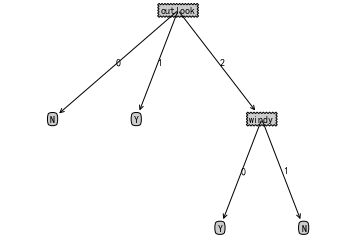

classifyResult:
 ['N', 'N', 'Y', 'N', 'Y', 'Y', 'N']


In [5]:
from math import log
import operator
# import treePlotter

def calcShannonEnt(dataSet):
    """
    输入：数据集
    输出：数据集的香农熵
    描述：计算给定数据集的香农熵；熵越大，数据集的混乱程度越大
    """
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

def splitDataSet(dataSet, axis, value):
    """
    输入：数据集，选择维度，选择值
    输出：划分数据集
    描述：按照给定特征划分数据集；去除选择维度中等于选择值的项
    """
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

def chooseBestFeatureToSplit(dataSet):
    """
    输入：数据集
    输出：最好的划分维度
    描述：选择最好的数据集划分维度
    """
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGainRatio = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        splitInfo = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy
        if (splitInfo == 0): # fix the overflow bug
            continue
        infoGainRatio = infoGain / splitInfo     # 信息增益率选择最优划分属性
        if (infoGainRatio > bestInfoGainRatio):
            bestInfoGainRatio = infoGainRatio
            bestFeature = i
    return bestFeature

def majorityCnt(classList):
    """
    输入：分类类别列表
    输出：子节点的分类
    描述：数据集已经处理了所有属性，但是类标签依然不是唯一的，
          采用多数判决的方法决定该子节点的分类
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reversed=True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    """
    输入：数据集，特征标签
    输出：决策树
    描述：递归构建决策树，利用上述的函数
    """
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        # 类别完全相同，停止划分
        return classList[0]
    if len(dataSet[0]) == 1:
        # 遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    # 得到列表包括节点所有的属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

def classify(inputTree, featLabels, testVec):
    """
    输入：决策树，分类标签，测试数据
    输出：决策结果
    描述：跑决策树
    """
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

def classifyAll(inputTree, featLabels, testDataSet):
    """
    输入：决策树，分类标签，测试数据集
    输出：决策结果
    描述：跑决策树
    """
    classLabelAll = []
    for testVec in testDataSet:
        classLabelAll.append(classify(inputTree, featLabels, testVec))
    return classLabelAll

def storeTree(inputTree, filename):
    """
    输入：决策树，保存文件路径
    输出：
    描述：保存决策树到文件
    """
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

def grabTree(filename):
    """
    输入：文件路径名
    输出：决策树
    描述：从文件读取决策树
    """
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

def createDataSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    dataSet = [[0, 0, 0, 0, 'N'], 
               [0, 0, 0, 1, 'N'], 
               [1, 0, 0, 0, 'Y'], 
               [2, 1, 0, 0, 'Y'], 
               [2, 2, 1, 0, 'Y'], 
               [2, 2, 1, 1, 'N'], 
               [1, 2, 1, 1, 'Y']]
    labels = ['outlook', 'temperature', 'humidity', 'windy']
    return dataSet, labels

def createTestSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    testSet = [[0, 1, 0, 0], 
               [0, 2, 1, 0], 
               [2, 1, 1, 0], 
               [0, 1, 1, 1], 
               [1, 1, 0, 1], 
               [1, 0, 1, 0], 
               [2, 1, 0, 1]]
    return testSet

def main():
    dataSet, labels = createDataSet()
    labels_tmp = labels[:] # 拷贝，createTree会改变labels
    desicionTree = createTree(dataSet, labels_tmp)
    #storeTree(desicionTree, 'classifierStorage.txt')
    #desicionTree = grabTree('classifierStorage.txt')
    print('desicionTree:\n', desicionTree)
    createPlot(desicionTree)
    testSet = createTestSet()
    print('classifyResult:\n', classifyAll(desicionTree, labels, testSet))

if __name__ == '__main__':
    main()